# Clustering Of Psychometric Data

### Psychometric Data:
The data is from online respondent results of the Big Five Personality Test. THe BIg FIve groups personalities according to Five General Categories:  Openness, Conscientiousness, Extroversion, Agreeableess and Neuroticism (Emotional Balance).  The data set consists of close to 20 thousand people who have taken the exam.  The exam consists of 50 questions plus several demographic questions.


In [1]:
from __future__ import print_function
import time
import numpy as np
import pandas as pd
from statsmodels.formula.api import ols
from statsmodels.stats.outliers_influence import variance_inflation_factor
import statsmodels.api as sm
import scipy.stats as stats
from scipy.spatial.distance import cdist 
from scipy.spatial import distance
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Lasso, Ridge, LinearRegression
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')
%matplotlib inline
import plotly.graph_objects as go
import plotly.express as px

In [2]:
# Reading data into notebook:

big_five_scored = pd.read_csv('../Data/Big_Five_scored.csv')
print(big_five_scored.shape)
big_five_scored.head()

(19719, 62)


EmployeeNumber                  race  age  English  gender  hand  source  \
0             1.0  Caucasian (European)   53        1       1     1       1   
1             2.0            Mixed Race   46        1       0     1       1   
2             4.0            Mixed Race   14        0       0     1       1   
3             5.0  Caucasian (European)   19        0       0     1       1   
4             7.0            Mixed Race   25        0       0     1       2   

  country  Openness  Conscieniousness  ...  O1(1)  O2(-1)  O3(1)  O4(-1)  \
0      US      25.0              23.0  ...      4       1      3       1   
1      US       8.0              18.0  ...      3       3      3       3   
2      PK      27.0              25.0  ...      4       5      5       1   
3      RO      23.0               2.0  ...      4       3      5       2   
4      US      16.0              10.0  ...      3       1      1       1   

   O5(1)  O6(-1)  O7(1)  O8(1)  O9(1)  O10(1)  
0      5       1      4      2      5       5  
1      2       3      3      1      3       2  
2      5       1      5      5      5       5  
3      4       2      5      2      5       5  
4      3       1      3      1      5       3  

[5 rows x 62 columns]

In [3]:
questions = ['E2(-1)', 'E4(-1)','E6(-1)', 'E8(-1)',  'E10(-1)', 'N1(-1)',
             'N3(-1)',  'N5(-1)', 'N6(-1)', 'N7(-1)', 'N8(-1)','N9(-1)', 'N10(-1)', 'A1(-1)', 'A3(-1)', 'A5(-1)',
             'A7(-1)', 'C2(-1)', 'C4(-1)',  'C6(-1)', 'C8(-1)', 
             'O2(-1)', 'O4(-1)', 'O6(-1)']

### Scoring
Some of the questions are framed negatively and in those cases, the scoring has a negative weight.  Accordingly, columns that are noted with (-1) indicate this negative weight.  

In [4]:
for question in questions:
    big_five_scored[question] = big_five_scored[question].map({1: 5, 2: 4, 3: 3, 4: 2, 5:1}) 

In [5]:
big_five_scored.head()

EmployeeNumber                  race  age  English  gender  hand  source  \
0             1.0  Caucasian (European)   53        1       1     1       1   
1             2.0            Mixed Race   46        1       0     1       1   
2             4.0            Mixed Race   14        0       0     1       1   
3             5.0  Caucasian (European)   19        0       0     1       1   
4             7.0            Mixed Race   25        0       0     1       2   

  country  Openness  Conscieniousness  ...  O1(1)  O2(-1)  O3(1)  O4(-1)  \
0      US      25.0              23.0  ...      4     5.0      3     5.0   
1      US       8.0              18.0  ...      3     3.0      3     3.0   
2      PK      27.0              25.0  ...      4     1.0      5     5.0   
3      RO      23.0               2.0  ...      4     3.0      5     4.0   
4      US      16.0              10.0  ...      3     5.0      1     5.0   

   O5(1)  O6(-1)  O7(1)  O8(1)  O9(1)  O10(1)  
0      5     5.0      4      2      5       5  
1      2     3.0      3      1      3       2  
2      5     5.0      5      5      5       5  
3      4     4.0      5      2      5       5  
4      3     5.0      3      1      5       3  

[5 rows x 62 columns]

### Changing Column Names

In [6]:
big_five_scored = big_five_scored.rename(columns=
                                 {'Neuroticism' : 'Emotional Balance', 'E1(1)' : 'E1',  'E2(-1)': 'E2', 'E3(1)' : 'E3','E4(-1)': 'E4', 'E5(1)': 'E5',
 'E6(-1)' : 'E6', 'E7(1)' : 'E7', 'E8(-1)' : 'E8', 'E9(1)' : 'E9', 'E10(-1)' : 'E10', 'N1(-1)' : 'N1', 'N2(1)' : 'N2',
 'N3(-1)' : 'N3', 'N4(1)' : 'N4','N5(-1)' : 'N5', 'N6(-1)' : 'N6', 'N7(-1)' : 'N7', 'N8(-1)' : 'N8', 'N9(-1)' : 'N9', 
 'N10(-1)' : 'N10', 'A1(-1)' : 'A1', 'A2(1)' : 'A2', 'A3(-1)': 'A3','A4(1)' : 'A4', 'A5(-1)' : 'A5', 'A6(1)' : 'A6',
 'A7(-1)' : 'A7', 'A8(1)' : 'A8', 'A9(1)' : 'A9', 'A10(1)' : 'A10', 'C1(1)' : 'C1', 'C2(-1)' : 'C2', 'C3(1)' : 'C3', 
 'C4(-1)' : 'C4', 'C5(1)' : 'C5', 'C6(-1)' : 'C6', 'C7(1)': 'C7', 'C8(-1)' : 'C8', 'C9(1)' : 'C9', 
 'C10(1)' : 'C10', 'O1(1)' : 'O1', 'O2(-1)' : 'O2', 'O3(1)' : 'O3', 'O4(-1)' : 'O4', 
 'O5(1)' : 'O5', 'O6(-1)' : 'O6', 'O7(1)' : 'O7', 'O8(1)' : 'O8', 'O9(1)' : 'O9', 'O10(1)' : 'O10'})

In [7]:
big_five_scored.head()

EmployeeNumber                  race  age  English  gender  hand  source  \
0             1.0  Caucasian (European)   53        1       1     1       1   
1             2.0            Mixed Race   46        1       0     1       1   
2             4.0            Mixed Race   14        0       0     1       1   
3             5.0  Caucasian (European)   19        0       0     1       1   
4             7.0            Mixed Race   25        0       0     1       2   

  country  Openness  Conscieniousness  ...  O1   O2  O3   O4  O5   O6  O7  O8  \
0      US      25.0              23.0  ...   4  5.0   3  5.0   5  5.0   4   2   
1      US       8.0              18.0  ...   3  3.0   3  3.0   2  3.0   3   1   
2      PK      27.0              25.0  ...   4  1.0   5  5.0   5  5.0   5   5   
3      RO      23.0               2.0  ...   4  3.0   5  4.0   4  4.0   5   2   
4      US      16.0              10.0  ...   3  5.0   1  5.0   3  5.0   3   1   

   O9  O10  
0   5    5  
1   3    2  
2   5    5  
3   5    5  
4   5    3  

[5 rows x 62 columns]

In [8]:
big_five_scored.isna().sum()

EmployeeNumber    18249
race                  0
age                   0
English               0
gender                0
                  ...  
O6                    1
O7                    0
O8                    0
O9                    0
O10                   0
Length: 62, dtype: int64

In [9]:
big_five_scored.to_csv('score_revised_1.csv')

In [10]:
scored =pd.read_csv('../data/big_five_final.csv')

In [11]:
scored

race  age  English  gender  hand        source  \
0         Caucasian (European)   53        1       1     1  Test Website   
1                   Mixed Race   46        1       0     1  Test Website   
2                   Mixed Race   14        0       0     1  Test Website   
3         Caucasian (European)   19        0       0     1  Test Website   
4                   Mixed Race   25        0       0     1        Google   
...                        ...  ...      ...     ...   ...           ...   
19714               Mixed Race   15        1       0     1        Google   
19715     Caucasian (European)   37        1       0     1        Google   
19716  Caucasian (Middle East)   16        0       1     1        Google   
19717              Mixed Race2   16        1       1     1  Other Source   
19718     Caucasian (European)   35        1       1     1  Test Website   

      country  Openness  Conscieniousness  Extroversion  Agreeableness  \
0          US        43                47            44             46   
1          US        26                42            22             35   
2          PK        45                49            35             38   
3          RO        41                26            22             37   
4          US        34                34            34             44   
...       ...       ...               ...           ...            ...   
19714      SG        35                36            20             42   
19715      US        30                32            23             36   
19716      US        37                23            19             26   
19717      NG        42                43            20             38   
19718      US        49                36            22             35   

       Emotional Balance  
0                     49  
1                     29  
2                     14  
3                     17  
4                     30  
...                  ...  
19714                 19  
19715                 39  
19716                 10  
19717                 20  
19718                 23  

[19719 rows x 12 columns]

### Categoricals to Dummy Variables

In [12]:
scored = pd.get_dummies(scored)
scored.head()

age  English  gender  hand  Openness  Conscieniousness  Extroversion  \
0   53        1       1     1        43                47            44   
1   46        1       0     1        26                42            22   
2   14        0       0     1        45                49            35   
3   19        0       0     1        41                26            22   
4   25        0       0     1        34                34            34   

   Agreeableness  Emotional Balance  race_2  ...  country_US  country_UY  \
0             46                 49       0  ...           1           0   
1             35                 29       0  ...           1           0   
2             38                 14       0  ...           0           0   
3             37                 17       0  ...           0           0   
4             44                 30       0  ...           1           0   

   country_UZ  country_VC  country_VE  country_VI  country_VN  country_ZA  \
0           0           0           0           0           0           0   
1           0           0           0           0           0           0   
2           0           0           0           0           0           0   
3           0           0           0           0           0           0   
4           0           0           0           0           0           0   

   country_ZM  country_ZW  
0           0           0  
1           0           0  
2           0           0  
3           0           0  
4           0           0  

[5 rows x 184 columns]

In [13]:
scored.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19719 entries, 0 to 19718
Columns: 184 entries, age to country_ZW
dtypes: int64(9), uint8(175)
memory usage: 4.6 MB


### Clustering by K-Means


Clustering of whole data set:

In [14]:
# Distortion is the average of the squared distances from the clusters centers of each cluster
distortions = [] 
# Inertia is the sum of squared distances of samples to their closest cluster center.
inertias = [] 
mapping1 = {} 
mapping2 = {} 
K = range(1,10) 
  
for k in K: 
    #Building and fitting the model 
    kmeanModel = KMeans(n_clusters=k).fit(scored) 
    kmeanModel.fit(scored)     
      
    distortions.append(sum(np.min(cdist(scored, kmeanModel.cluster_centers_, 
                      'euclidean'),axis=1)) / scored.shape[0]) 
    inertias.append(kmeanModel.inertia_) 
  
    mapping1[k] = sum(np.min(cdist(scored, kmeanModel.cluster_centers_, 
                 'euclidean'),axis=1)) / scored.shape[0] 
    mapping2[k] = kmeanModel.inertia_ 

In [15]:

for key,val in mapping1.items(): 
    print(str(key)+' : '+str(val)) 

1 : 101456.55736974717
2 : 61.95980222996859
3 : 28.338957869174507
4 : 19.46864742171852
5 : 17.25979856495362
6 : 15.924738122409824
7 : 15.276949203819234
8 : 14.777167837258467
9 : 14.436567881252373


In [16]:
# fig = px.line(df, x="year", y="lifeExp", title='Life expectancy in Canada')
# fig.show()

In [17]:
fig = px.line(x= K, y= distortions, title='Elbow Method- Distortion')
fig.show()

In [18]:
kmeans = KMeans(n_clusters=2).fit(scored)
kmeans.labels_

kmeans.predict(scored)

first_k_cluster = kmeans.cluster_centers_

In [19]:
# first_k_cluster

In [20]:
# # first_k_cluster = kmeans.cluster_centers_
# plt.scatter(x[:, 0], x[:, 1], c=y_kmeans_5, s=50, cmap='viridis')
# plt.scatter(first_k_cluster[:, 0], first_k_cluster[:, 1], c='black', s=200, alpha=0.5);

Clustering of 5 Psychometric Categories Only:

In [21]:
scored.head()

age  English  gender  hand  Openness  Conscieniousness  Extroversion  \
0   53        1       1     1        43                47            44   
1   46        1       0     1        26                42            22   
2   14        0       0     1        45                49            35   
3   19        0       0     1        41                26            22   
4   25        0       0     1        34                34            34   

   Agreeableness  Emotional Balance  race_2  ...  country_US  country_UY  \
0             46                 49       0  ...           1           0   
1             35                 29       0  ...           1           0   
2             38                 14       0  ...           0           0   
3             37                 17       0  ...           0           0   
4             44                 30       0  ...           1           0   

   country_UZ  country_VC  country_VE  country_VI  country_VN  country_ZA  \
0           0           0           0           0           0           0   
1           0           0           0           0           0           0   
2           0           0           0           0           0           0   
3           0           0           0           0           0           0   
4           0           0           0           0           0           0   

   country_ZM  country_ZW  
0           0           0  
1           0           0  
2           0           0  
3           0           0  
4           0           0  

[5 rows x 184 columns]

In [22]:
psychometrics = scored.iloc[:, 4:9]

In [23]:
psychometrics = pd.DataFrame(psychometrics)
psychometrics.shape

(19719, 5)

In [24]:
psychometrics.head()

Openness  Conscieniousness  Extroversion  Agreeableness  Emotional Balance
0        43                47            44             46                 49
1        26                42            22             35                 29
2        45                49            35             38                 14
3        41                26            22             37                 17
4        34                34            34             44                 30

### Scaling
Althought he data doesn't need to be scaled, I did so to get an array object

In [25]:
# preprocess the data 

from sklearn.preprocessing import StandardScaler
# Separating out the features
x = psychometrics.values

# Standardizing the features
x = StandardScaler().fit_transform(x)

In [26]:
# Distortion is the average of the squared distances from the clusters centers of each cluster
distortions = [] 
# Inertia is the sum of squared distances of samples to their closest cluster center.
inertias = [] 
mapping1 = {} 
mapping2 = {} 
K = range(1,10) 
  
for k in K: 
    #Building and fitting the model 
    kmeanModel = KMeans(n_clusters=k).fit(x) 
    kmeanModel.fit(x)     
      
    distortions.append(sum(np.min(cdist(x, kmeanModel.cluster_centers_, 
                      'euclidean'),axis=1)) / scored.shape[0]) 
    inertias.append(kmeanModel.inertia_) 
  
    mapping1[k] = sum(np.min(cdist(x, kmeanModel.cluster_centers_, 
                 'euclidean'),axis=1)) / x.shape[0] 
    mapping2[k] = kmeanModel.inertia_ 

In [27]:

for key,val in mapping1.items(): 
    print(str(key)+' : '+str(val)) 

1 : 2.112800583026997
2 : 1.8631078588882681
3 : 1.7531939853182603
4 : 1.6635782229048683
5 : 1.597476394606622
6 : 1.5387114768161714
7 : 1.4970609083759945
8 : 1.4611513671479408
9 : 1.4331424813908669


In [28]:
fig = px.line(x= K, y= distortions, title='Elbow Method- Distortion')
fig.show()

In [29]:
kmeans = KMeans(n_clusters=2).fit(x)
kmeans.labels_

kmeans.predict(x)

first_k_cluster = kmeans.cluster_centers_
first_k_cluster

array([[ 0.32111705,  0.39721372,  0.60512949,  0.51164667,  0.48112509],
       [-0.3134898 , -0.38777899, -0.5907563 , -0.49949391, -0.46969728]])

In [30]:
clusters = kmeans.predict(x)

In [31]:
psychometrics["Cluster"]= clusters
psychometrics.head()

Openness  Conscieniousness  Extroversion  Agreeableness  Emotional Balance  \
0        43                47            44             46                 49   
1        26                42            22             35                 29   
2        45                49            35             38                 14   
3        41                26            22             37                 17   
4        34                34            34             44                 30   

   Cluster  
0        0  
1        1  
2        0  
3        1  
4        0

In [32]:
psychometrics = psychometrics.rename(columns = {'Emotional Balance':'Neuroticism'})
psychometrics.head()

Openness  Conscieniousness  Extroversion  Agreeableness  Neuroticism  \
0        43                47            44             46           49   
1        26                42            22             35           29   
2        45                49            35             38           14   
3        41                26            22             37           17   
4        34                34            34             44           30   

   Cluster  
0        0  
1        1  
2        0  
3        1  
4        0

In [33]:
first_cluster = psychometrics[psychometrics['Cluster'] == 0]   
second_cluster =  psychometrics[psychometrics['Cluster'] == 1] 

In [34]:
second_cluster

Openness  Conscieniousness  Extroversion  Agreeableness  Neuroticism  \
1            26                42            22             35           29   
3            41                26            22             37           17   
5            33                31            16             36           36   
9            41                40            15             35           23   
10           42                24            13             41           24   
...         ...               ...           ...            ...          ...   
19714        35                36            20             42           19   
19715        30                32            23             36           39   
19716        37                23            19             26           10   
19717        42                43            20             38           20   
19718        49                36            22             35           23   

       Cluster  
1            1  
3            1  
5            1  
9            1  
10           1  
...        ...  
19714        1  
19715        1  
19716        1  
19717        1  
19718        1  

[10000 rows x 6 columns]

In [35]:
first_cluster.describe()

Openness  Conscieniousness  Extroversion  Agreeableness  \
count  9719.000000       9719.000000   9719.000000    9719.000000   
mean     41.091985         36.379360     32.829818      42.110505   
std       5.255127          6.716531      6.745045       5.212892   
min      16.000000         11.000000      9.000000      14.000000   
25%      38.000000         32.000000     28.000000      39.000000   
50%      42.000000         37.000000     33.000000      43.000000   
75%      45.000000         41.000000     38.000000      46.000000   
max      50.000000         50.000000     50.000000      50.000000   

       Neuroticism  Cluster  
count  9719.000000   9719.0  
mean     33.187159      0.0  
std       7.745771      0.0  
min      10.000000      0.0  
25%      28.000000      0.0  
50%      33.000000      0.0  
75%      39.000000      0.0  
max      50.000000      0.0

In [36]:
second_cluster.describe()

Openness  Conscieniousness  Extroversion  Agreeableness  \
count  10000.000000      10000.000000  10000.000000   10000.000000   
mean      37.136800         30.645800     22.662800      34.879700   
std        6.538621          6.732761      6.860758       6.974259   
min        0.000000          0.000000      0.000000       0.000000   
25%       33.000000         26.000000     18.000000      31.000000   
50%       37.000000         31.000000     23.000000      36.000000   
75%       42.000000         35.000000     27.000000      40.000000   
max       50.000000         50.000000     45.000000      50.000000   

        Neuroticism  Cluster  
count  10000.000000  10000.0  
mean      24.984500      1.0  
std        7.417436      0.0  
min        0.000000      1.0  
25%       20.000000      1.0  
50%       25.000000      1.0  
75%       30.000000      1.0  
max       50.000000      1.0

In [37]:
# Openness = description['Openness']
# Conscieniousness = description['Conscieniousness']
# Extroversion = description['Extroversion']
# Agreeableness = description['Agreeableness']
# Emotional_Balance = description['Emotional Balance']

In [38]:
# x_df = pd.DataFrame(x)
# print(x_df.shape)
# x_df.head()

In [39]:
# psychometrics.describe()

In [40]:
# x_df.describe()

### Psychometric Historgrams

In [41]:
# Openness
cluster_1 = first_cluster['Openness']
cluster_2 = second_cluster['Openness'] 

fig = go.Figure()

fig.add_trace(go.Histogram(
    x= cluster_1,
 
    name="Open"       # this sets its legend entry
))


fig.add_trace(go.Histogram(
    x= cluster_2,
 
    name="Closed"       # this sets its legend entry
))


fig.update_layout(
    title="Openness to Experience",
    xaxis_title="Openness Score",
    yaxis_title="Count",
    font=dict(
        family="Garamond, monospace",
        size=18,
        color="#8c564b"
    )
)

fig.show()

In [42]:
cluster_1 = first_cluster['Conscieniousness']
cluster_2 = second_cluster['Conscieniousness'] 

fig = go.Figure()

fig.add_trace(go.Histogram(
    x= cluster_1,
 
    name="Conscientiousness"       # this sets its legend entry
))


fig.add_trace(go.Histogram(
    x= cluster_2,
 
    name="Unreliable"       # this sets its legend entry
))


fig.update_layout(
    title="conscientiousness",
    xaxis_title="Conscientiousness Score",
    yaxis_title="Count",
    font=dict(
        family="Garamond, monospace",
        size=18,
        color="#7f7f7f"
    )
)

fig.show()

In [43]:
cluster_1 = first_cluster['Extroversion']
cluster_2 = second_cluster['Extroversion'] 

fig = go.Figure()

fig.add_trace(go.Histogram(
    x= cluster_1,
 
    name="Extroverted"       # this sets its legend entry
))


fig.add_trace(go.Histogram(
    x= cluster_2,
 
    name="Introverted"       # this sets its legend entry
))


fig.update_layout(
    title="Extroversion",
    xaxis_title="Extroversion Score",
    yaxis_title="Count",
    font=dict(
        family="Garamond, monospace",
        size=18,
        color="#7f7f7f"
    )
)

fig.show()

In [44]:
cluster_1 = first_cluster['Agreeableness']
cluster_2 = second_cluster['Agreeableness'] 

fig = go.Figure()

fig.add_trace(go.Histogram(
    x= cluster_1,
 
    name="Agreeable"       # this sets its legend entry
))


fig.add_trace(go.Histogram(
    x= cluster_2,
 
    name="Antagonistic"       # this sets its legend entry
))


fig.update_layout(
    title="Agreeableness",
    xaxis_title="Extroversion Score",
    yaxis_title="Count",
    font=dict(
        family="Garamond, monospace",
        size=18,
        color="#7f7f7f"
    )
)

fig.show()

In [45]:
# second_cluster = second_cluster.rename(columns={'Emotional Balance': 'Neuroticism'})
# second_cluster.columns

In [46]:
cluster_1 = first_cluster['Neuroticism']
cluster_2 = second_cluster['Neuroticism']

fig = go.Figure()

fig.add_trace(go.Histogram(
    x= cluster_1,
 
    name="Neurotic"       # this sets its legend entry
))


fig.add_trace(go.Histogram(
    x= cluster_2,
 
    name="Emotionally Stable"       # this sets its legend entry
))


fig.update_layout(
    title="Neuroticism",
    xaxis_title="Neuroticism Score",
    yaxis_title="Count",
    font=dict(
        family="Garamond, monospace",
        size=18,
        color="#7f7f7f"
    )
)

fig.show()

In [47]:
first_cluster['Neuroticism']

0        49
2        14
4        30
6        39
7        45
         ..
19702    47
19704    39
19705    19
19706    32
19712    43
Name: Neuroticism, Length: 9719, dtype: int64

In [48]:
def multi_hist_plot(df_1, df_2, to_plot):
    #takes 2 dataframes and a column to create a hist plot on
    fig = plt.figure()
    plt.style.use('seaborn')
    sns.set_palette('colorblind')
    hist_1 = sns.distplot(df_1[to_plot].astype(float), kde = False)
    hist_2 = sns.distplot(df_2[to_plot].astype(float), kde = False)
    plt.show()

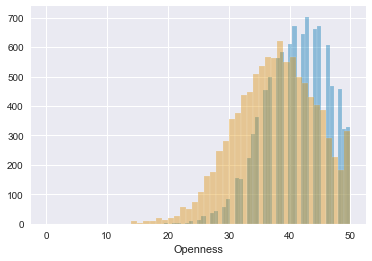

In [49]:
# Plotting Oppenness for cluster 1 and 2
multi_hist_plot(first_cluster, second_cluster, "Openness")

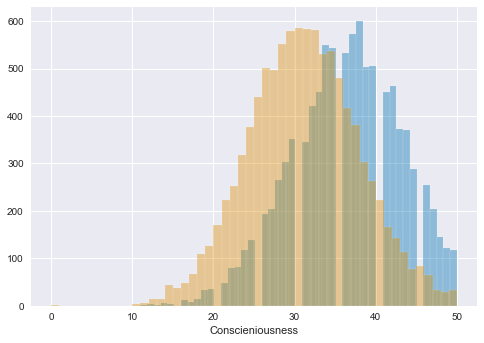

In [50]:
# Plotting Conscieniousness for cluster 1 and 2
multi_hist_plot(first_cluster, second_cluster, "Conscieniousness")

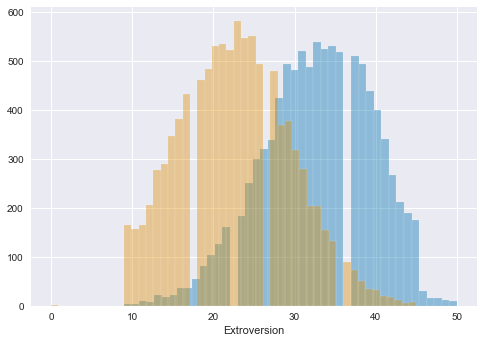

In [51]:
# Plotting Extroversion for cluster 1 and 2
multi_hist_plot(first_cluster, second_cluster, "Extroversion")

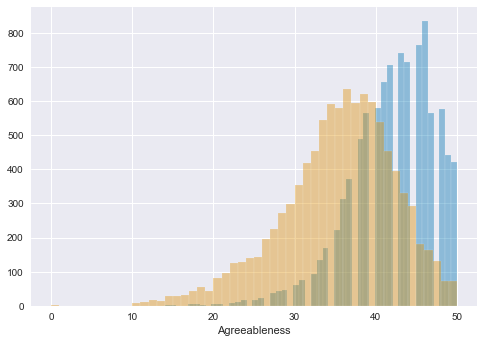

In [52]:
# Plotting Agreeableness for cluster 1 and 2
multi_hist_plot(first_cluster, second_cluster, "Agreeableness")

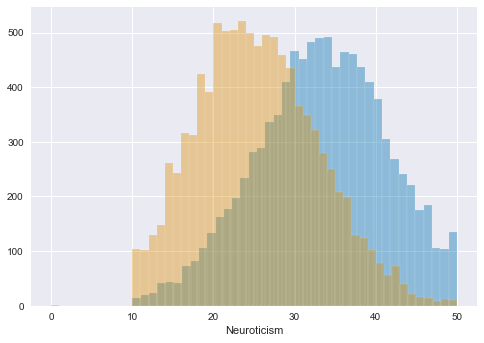

In [53]:
# Plotting Emotional Balance for cluster 1 and 2
multi_hist_plot(first_cluster, second_cluster, "Neuroticism")

In [54]:
pyplot.hist(x, bins, alpha=0.5, label='x')
pyplot.hist(y, bins, alpha=0.5, label='y')
pyplot.legend(loc='upper right')
pyplot.show()


NameError: name 'pyplot' is not defined

In [ ]:
psychometrics.columns

In [ ]:
# Openness:
plt.hist(x[:, 0], bins = 10, color='c')

In [ ]:
# Conscieniousness:
plt.hist(x[:, 1], bins = 10, color='m')

In [ ]:
# Extroversion:
plt.hist(x[:, 2], bins = 10, color='r')

In [ ]:
# Agreeableness:
plt.hist(x[:, 3], bins = 10, color='b')

In [ ]:
# Emotional Balance:
plt.hist(x[:, 4], bins = 10, color='g')

### Scatterplots between Openness and each of the other four psychometric categories

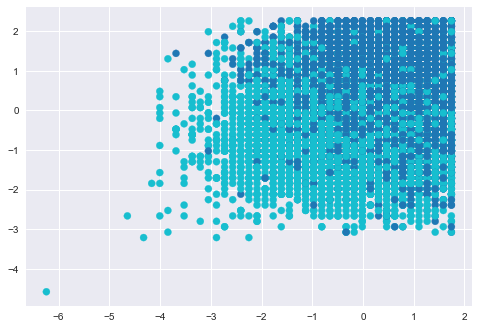

In [55]:
# Scatter plot for 0- Openness and 1 Conscientiousness
plt.scatter(x[:, 0], x[:, 1], c=clusters, s=50, cmap='tab10')

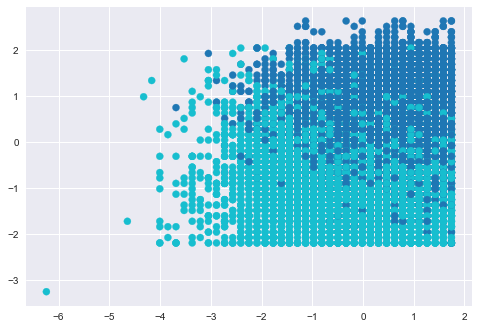

In [56]:
# Scatter plot for 0- Openness and 2 Extroversion
plt.scatter(x[:, 0], x[:, 2], c=clusters, s=50, cmap='tab10')

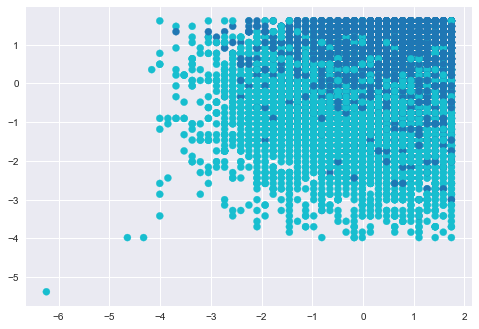

In [57]:
# Scatter plot for 0- Openness and 3 Agreeableness
plt.scatter(x[:, 0], x[:, 3], c=clusters, s=50, cmap='tab10')

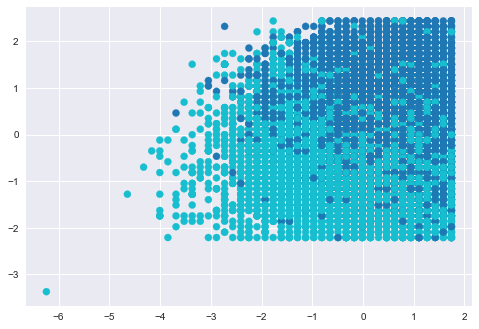

In [58]:
# Scatter plot for 0- Openness and 4 Emotional Balance
plt.scatter(x[:, 0], x[:, 4], c=clusters, s=50, cmap='tab10')

### Scatter plots with Concientiousness

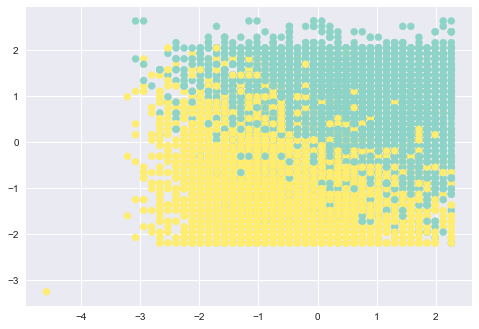

In [59]:
# Scatter plot for 1- Conscientiousnes and 2 Extroversion
plt.scatter(x[:, 1], x[:, 2], c=clusters, s=50, cmap='Set3')

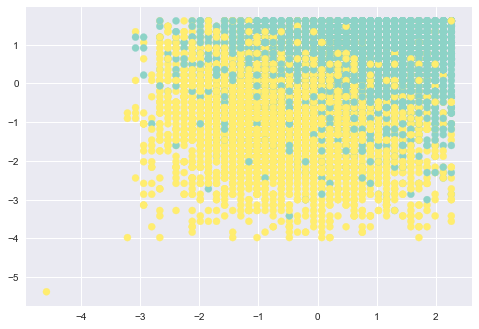

In [60]:
# Scatter plot for 1- Conscientiousnes and 3 Agreeableness
plt.scatter(x[:, 1], x[:, 3], c=clusters, s=50, cmap='Set3')

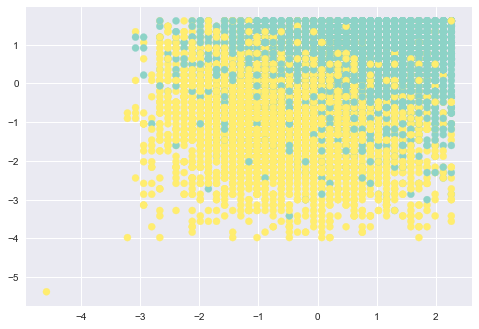

In [61]:
# Scatter plot for 1- Conscientiousnes and 4 Emotional Balance
plt.scatter(x[:, 1], x[:, 3], c=clusters, s=50, cmap='Set3')

In [ ]:
# From Jackson:
#def multi_hist_plot(df_1, df_2, to_plot):
#     #takes 2 dataframes and a column to create a hist plot on
#     fig = plt.figure()
#     plt.style.use('seaborn')
#     sns.set_palette('colorblind')
#     hist_1 = sns.distplot(df_1[to_plot].astype(float), kde = False)
#     hist_2 = sns.distplot(df_2[to_plot].astype(float), kde = False)
    

### T- Distributed Stochastic Neighbor Embedding (TSNE):
Using TSNE on psychmoetric data for dimensionality reduction in order to visualize psychometric clusters:

In [ ]:
X_psychometric = TSNE(n_components=2).fit_transform(psychometrics)
X_psychometric.shape

In [ ]:
# Initializing TSNE dimension reduction 
time_start = time.time()
tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
tsne_results = tsne.fit_transform(psychometrics)
print('t-SNE completed. Time elapsed: {} seconds'.format(time.time()-time_start))

# This part for review

In [ ]:
#T-SNE with two dimensions
# plotX.drop(["Cluster"], axis=1
# from Brittany: tsne_2d = TSNE(n_components=2, perplexity=perplexity)

#This DataFrame contains two dimensions, built by T-SNE
# df_name = pd.DataFrame(tsne.fit_transform(psychometrics)))



# X_psychometric_embedded = TSNE(n_components=2).fit_transform(psychometrics)


In [ ]:
psychometrics